In [163]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import random
from scipy.sparse import csr_matrix

from tqdm import tqdm
from collections import defaultdict

from joblib import Parallel, delayed


from implicit.als import AlternatingLeastSquares

from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import VALID_METRICS, NearestNeighbors
from sklearn.metrics import roc_auc_score, classification_report, silhouette_score

import optuna

from tqdm.notebook import tqdm as tqdm_notebook

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean  # Для гармонического среднего

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

random.seed(42)
np.random.seed(42)

In [124]:
import faiss

# Общие комменты
- не забыть про финальную фильтрацию резов: если юзер уже смотрел фильм, то вероятно второй раз не посмотрит, если он смотрит только популярное 

Задача рекомендаций фильмов пользователям на основе истории оценок.
В качестве сабмита необходимо предоставить 10 рекомендуемых фильмов для каждого пользователя (см. submission_sample.csv).

Метрика: recall@10

Для зачета домашнего задания необходимо:

Предоставить командный git репозиторий. В репозитории должна быть указана роль каждого члена команды (отмечен скрипт/часть скрипта каждого члена команды).
Метрики в репозитории должны быть воспроизводимы

In [2]:
path = r'hw1/hse-rec-sys-challenge-2024/'

events = pd.read_csv(os.path.join(path, 'events.csv'))
item_features = pd.read_csv(os.path.join(path, 'item_features.csv'))
submission_sample = pd.read_csv(os.path.join(path, 'submission_sample.csv'))
user_features = pd.read_csv(os.path.join(path, 'user_features.csv'))


'''
events.csv - интеракции пользователей (история оценок)
user_features.csv - признаки пользователя
item_features.csv - признаки фильмов
submission_sample.csv - пример сабмита
Формат сабмита: user_id[str], item_id[str] - см submission_sample.csv
'''


'\nevents.csv - интеракции пользователей (история оценок)\nuser_features.csv - признаки пользователя\nitem_features.csv - признаки фильмов\nsubmission_sample.csv - пример сабмита\nФормат сабмита: user_id[str], item_id[str] - см submission_sample.csv\n'

In [3]:
display(events.head(2), item_features.head(2), submission_sample.head(2), user_features.head(2))

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1


,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


,user_id,item_id
0,0,0 1 2 3 4 5 6 7 8 9
1,1,0 1 2 3 4 5 6 7 8 9


,user_id,gender,age
0,4855,F,1
1,4065,M,56


In [4]:
events.groupby('user_id')['item_id'].nunique().sort_values(ascending=True)

user_id
488       14
3123      15
1943      15
4112      15
5856      15
        ... 
4018    1390
4635    1438
4285    1544
69      1675
2257    2056
Name: item_id, Length: 6040, dtype: int64

## Сделаем изначальный сплит на трейн вал тест для бустинга. Далее сплиты будут выполняться на полученной выборке трейн.

In [76]:
# Функция для разделения данных на train, val, test (User time split)
def train_val_test_split(df, val_size=0.1, test_size=0.1):
    train_data, val_data, test_data = [], [], []
    
    for user in df['user_id_idx'].unique():
        user_data = df[df['user_id_idx'] == user].sort_values('timestamp')
        n = len(user_data)
        
        # Для вал выборке отбираем 5 фильмов, для теста - 10
        test_split = max(int(n * (1 - test_size)), (n - 10))
        val_split = max(int(test_split * (1 - val_size)), (n - 15))
        
        train_data.append(user_data.iloc[:val_split])
        val_data.append(user_data.iloc[val_split:test_split])
        test_data.append(user_data.iloc[test_split:])
    
    train_data = pd.concat(train_data)
    val_data = pd.concat(val_data)
    test_data = pd.concat(test_data)
    
    return train_data, val_data, test_data


# Создаем разреженные матрицы взаимодействий
def create_sparse_matrix(df, n_users, n_items):
    # строки - пользователи, столбцы - айтемы (user-item матрица)
    return csr_matrix((df['rating'], (df['user_id_idx'], df['item_id_idx'])), shape=(n_users, n_items))

In [77]:
# Переиндексация user_id и item_id (чтобы индексы были последовательны и начинались с 0)
events['user_id_idx'], user_index = pd.factorize(events['user_id'])
events['item_id_idx'], item_index = pd.factorize(events['item_id'])


n_users_glob = events['user_id_idx'].nunique()
n_items_glob = events['item_id_idx'].nunique()
print(n_users_glob, n_items_glob)

6040 3690


In [78]:
# Разделяем данные для catboost
train_data_glob, val_data_glob, test_data_glob = train_val_test_split(events, val_size=0.1, test_size=0.1)

not_train_data_glob = pd.concat([val_data_glob, test_data_glob], axis=0) # Выборка для последнего скоринга

In [79]:
# Создаем разреженные матрицы взаимодействий
train_matrix_glob = create_sparse_matrix(train_data_glob, n_users_glob, n_items_glob)
val_matrix_glob = create_sparse_matrix(val_data_glob, n_users_glob, n_items_glob)
test_matrix_glob = create_sparse_matrix(test_data_glob, n_users_glob, n_items_glob)

not_train_matrix_glob = create_sparse_matrix(not_train_data_glob, n_users_glob, n_items_glob)

### Далее для обучения промежуточных моделей будем использовать выборку  **train_data_glob**

## Feature engineering

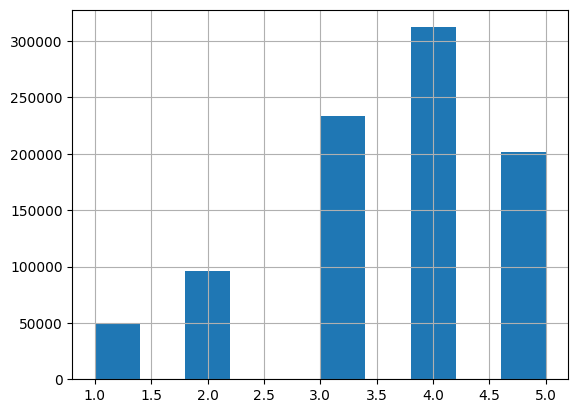

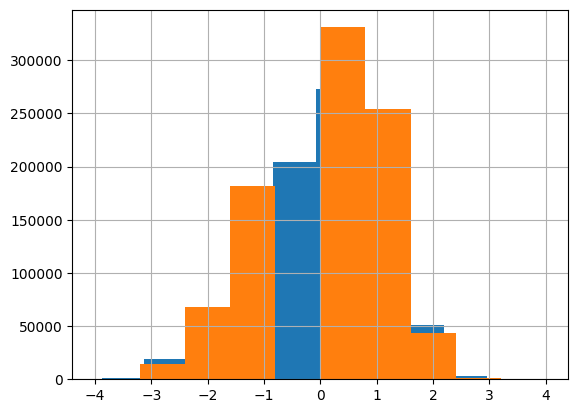

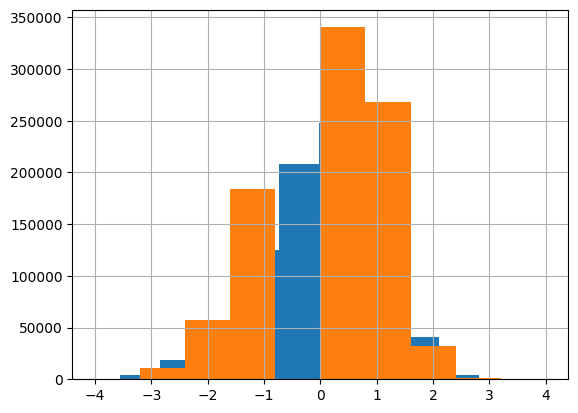

rating_user_normalized_round   -0.017844
rating_item_normalized_round    0.002703
dtype: float64

In [11]:
df = events.copy()

# Общее количество доступных фильмов
num_total_items = df['item_id'].nunique()

positive_threshold = 4

# Агрегация по 'user_id'
user_features_group = df.groupby('user_id').agg(
    user_avg_rating=('rating', 'mean'),
    user_min_rating=('rating', 'min'),
    user_max_rating=('rating', 'max'),
    user_rating_count=('rating', 'count'),
    user_rating_std=('rating', 'std'),
    user_unique_items=('item_id', 'nunique'),
    user_start_time=('timestamp', 'min'),
    last_user_activity=('timestamp', 'max'),
    user_activity_timedelta=('timestamp', lambda x: x.diff().mean()),

    # Количество фильмов, которые пользователь оценил положительно
    user_positive_items=("rating", lambda x: (x >= positive_threshold).sum()),
    # Доля непросмотренных фильмов (если есть информация о всех доступных фильмах)
    user_unwatched_ratio=('item_id', lambda x: 1 - x.nunique() / num_total_items)

    
).reset_index()

# Добавление доли положительных оценок

user_positive_count = df[df['rating'] >= positive_threshold].groupby('user_id')['rating'].count()
user_features_group = user_features_group.merge(user_positive_count.rename('user_positive_rating_count'), on='user_id', how='left')
user_features_group['user_positive_rating_ratio'] = user_features_group['user_positive_rating_count'].fillna(0) / user_features_group['user_rating_count']

# Вычисление отклонения от среднего
overall_avg_rating = df['rating'].mean()
user_features_group['user_bias'] = user_features_group['user_avg_rating'] - overall_avg_rating

# Агрегация по 'item_id'
item_features_group = df.groupby('item_id').agg(
    item_avg_rating=('rating', 'mean'),
    item_min_rating=('rating', 'min'),
    item_max_rating=('rating', 'max'),
    item_rating_count=('rating', 'count'),
    item_unique_users=('user_id', 'nunique'),
    last_item_rating_time=('timestamp', 'max'),
    first_item_rating_time=('timestamp', 'min'),

    # Разнообразие оценок (например, число уникальных оценок)
    item_rating_diversity=('rating', 'nunique')
).reset_index()

# Добавление доли положительных оценок
item_positive_count = df[df['rating'] >= positive_threshold].groupby('item_id')['rating'].count()
item_features_group = item_features_group.merge(item_positive_count.rename('item_positive_rating_count'), on='item_id', how='left')
item_features_group['item_positive_rating_ratio'] = item_features_group['item_positive_rating_count'].fillna(0) / item_features_group['item_rating_count']

# Присоединение вычисленных признаков обратно к исходному датафрейму
df = df.merge(user_features_group, on='user_id', how='left')
df = df.merge(item_features_group, on='item_id', how='left')

# Вычисление текущей новизны просмотра фильма
df['item_recency'] = df['last_item_rating_time'] - df['timestamp']
# Вычисление текущей старины просмотра фильма
df['item_olden'] = df['timestamp'] - df['first_item_rating_time']


# Средний рейтинг, полученный фильмом за последние N оценок
N_list = list(range(2, 51, 2))
df_sorted = df.sort_values(by=['item_id', 'timestamp'], ascending=[True, False])
for n in N_list:
    df_sorted[f'top_{n}_avg_rating_item'] = df_sorted.groupby('item_id')['rating'].transform(lambda x: x.head(n).mean())
    df = df.join(df_sorted.set_index(['user_id', 'item_id'])[f'top_{n}_avg_rating_item'], on=['user_id', 'item_id'], rsuffix='_recent')
del df_sorted


# Средний рейтинг, поставленный пользователем на последние N фильмов
N_list = list(range(2, 51, 2))
df_sorted = df.sort_values(by=['user_id', 'timestamp'], ascending=[True, False])
for n in N_list:
    df_sorted[f'top_{n}_avg_rating_user'] = df_sorted.groupby('item_id')['rating'].transform(lambda x: x.head(n).mean())
    df = df.join(df_sorted.set_index(['user_id', 'item_id'])[f'top_{n}_avg_rating_user'], on=['user_id', 'item_id'], rsuffix='_recent')
del df_sorted


# Кумулятивная средняя оценка юзера
df['rating_user_cumsum'] = df.groupby('user_id')['rating'].cumsum()
df['rating_user_cumcount'] = df.groupby('user_id')['rating'].cumcount()
df['rating_user_cummean'] = (df['rating_user_cumsum'] / df['rating_user_cumcount']).replace(np.inf, 0)

# Кумулятивная средняя оценка фильма
df['rating_item_cumsum'] = df.groupby('item_id')['rating'].cumsum()
df['rating_item_cumcount'] = df.groupby('item_id')['rating'].cumcount()
df['rating_item_cummean'] = (df['rating_item_cumsum'] / df['rating_item_cumcount']).replace(np.inf, 0)



df.rating.hist()
plt.show()

# Отнормированный рейтинг по пользователю с учетом его средней оценки, на практике получаем классическое норм расп оценок из изначально не нормального
# (Обычно такой прием хорошо работает на опросниках людей) 
df['rating_user_normalized'] = df['rating'] - df.groupby('user_id')['rating'].transform('mean')
df['rating_user_normalized_round'] = df['rating'] - df.groupby('user_id')['rating'].transform('mean').round(0)
df['rating_user_normalized'].hist(), df['rating_user_normalized_round'].hist()
plt.show()

# Отнормированный рейтинг по фильму с учетом его средней оценки
df['rating_item_normalized'] = df['rating'] - df.groupby('item_id')['rating'].transform('mean')
df['rating_item_normalized_round'] = df['rating'] - df.groupby('item_id')['rating'].transform('mean').round(0)
df['rating_item_normalized'].hist(), df['rating_item_normalized_round'].hist()
plt.show()

display(df[['rating_user_normalized_round', 'rating_item_normalized_round']].mean())

### Учет пола и возраста

In [12]:
# Пол переводим в булевую
user_features['gender'] = user_features['gender'].map({'M':1, 'F':0})
df = df.merge(user_features, on='user_id', how='left')

# Возраст уже забинен в колонке, уникальных значений мало и они логически разбиты на этапы жизни челяди, поэтому оставляем как есть
# Считаем схожие фичи, но с условием агрегации на пол и возраст
gender_age_features = df.groupby(['gender', 'age']).agg(
    gender_age_avg_rating=('rating', 'mean'),
    gender_age_min_rating=('rating', 'min'),
    gender_age_max_rating=('rating', 'max'),
    gender_age_rating_count=('rating', 'count'),
    gender_age_unique_users=('user_id', 'nunique'),
    gender_age_start_time=('timestamp', 'min'),
    gender_age_last_activity=('timestamp', 'max'),
    gender_age_positive_items=('rating', lambda x: (x >= positive_threshold).sum())
).reset_index()

user_gender_age_features = df.groupby(['user_id', 'gender', 'age']).agg(
    user_gender_age_avg_rating=('rating', 'mean'),
    user_gender_age_min_rating=('rating', 'min'),
    user_gender_age_max_rating=('rating', 'max'),
    user_gender_age_rating_count=('rating', 'count'),
    user_gender_age_positive_items=('rating', lambda x: (x >= positive_threshold).sum())
).reset_index()

user_gender_age_variance = df.groupby(['gender', 'age'])['rating'].var().reset_index(name='gender_age_rating_variance')
user_gender_age_std = df.groupby(['gender', 'age'])['rating'].std().reset_index(name='gender_age_rating_std')

gender_age_positive_ratio = gender_age_features['gender_age_positive_items'] / gender_age_features['gender_age_rating_count']
gender_age_features['gender_age_positive_ratio'] = gender_age_positive_ratio

overall_gender_age_avg_rating = df.groupby(['gender', 'age'])['rating'].mean().reset_index(name='overall_gender_age_avg_rating')

# Объединяем gender_age_features с основным df
df = df.merge(gender_age_features, on=['gender', 'age'], how='left', suffixes=('', '_by_gender_age'))
# Объединяем user_gender_age_features с основным df
df = df.merge(user_gender_age_features, on=['user_id', 'gender', 'age'], how='left', suffixes=('', '_by_user_gender_age'))
# Объединяем с дисперсией и стандартным отклонением оценок
df = df.merge(user_gender_age_variance, on=['gender', 'age'], how='left')
df = df.merge(user_gender_age_std, on=['gender', 'age'], how='left')
df = df.merge(overall_gender_age_avg_rating, on=['gender', 'age'], how='left')

df['user_gender_age_bias'] = df['user_avg_rating'] - df['overall_gender_age_avg_rating']

###  Split dataframe для базовых моделей

In [80]:
# Снова переиндексируем items, так как изменилось их общее количество (train стал меньше)
train_data_glob['item_id_idx'], item_index = pd.factorize(train_data_glob['item_id_idx'])

In [81]:
train_data, val_data, test_data = train_val_test_split(train_data_glob, val_size=0.1, test_size=0.1)

In [82]:
n_users = train_data_glob['user_id_idx'].nunique()
n_items = train_data_glob['item_id_idx'].nunique()
print(n_users, n_items)

6040 3684


In [83]:
# Создаем разреженные матрицы взаимодействий
train_matrix = create_sparse_matrix(train_data, n_users, n_items)
val_matrix = create_sparse_matrix(val_data, n_users, n_items)
test_matrix = create_sparse_matrix(test_data, n_users, n_items)

## ALS

In [84]:
# Функция для расчета Recall@10
def recall_at_k(model, user_items, test_items, k=10):
    recalls = []
    for user_id in range(user_items.shape[0]):
        # Проверяем, обучен ли моделью этот пользователь
        if user_id >= model.user_factors.shape[0]:
            print(f"User miss in train: {user_id}")
            continue
        
        # Получаем рекомендации для пользователя
        recommended_items = model.recommend(user_id, user_items[user_id], N=k)
        recommended_item_ids = set(recommended_items[0])
        
        # Истинные айтемы (из теста)
        true_item_ids = set(test_items[user_id].nonzero()[1])
        
        # Пропускаем, если нет истинных айтемов
        if len(true_item_ids) == 0:
            continue  
        
        # Считаем Recall
        recall = len(recommended_item_ids & true_item_ids) / len(true_item_ids)
        recalls.append(recall)
    
    return np.mean(recalls)

### Повторно можно не запускать (ниже запустить уже на найденных лучших гиперпараметрах)

In [ ]:
# Подбор гиперпараметров
param_grid = {
    'factors': [20, 50, 100, 150, 200, 300],
    'regularization': [0.01, 0.02, 0.05, 0.1],
    'iterations': [10, 15, 20]
}

best_score = -1
best_params = None


# Проходим по сетке параметров
for params in ParameterGrid(param_grid):
    model = AlternatingLeastSquares(factors=params['factors'], regularization=params['regularization'], iterations=params['iterations'], num_threads=8, random_state=42)
    model.fit(train_matrix, show_progress=False)
    
    # Recall@10
    score = recall_at_k(model, train_matrix, val_matrix, k=10)
    
    print(f"Параметры: {params}, Recall@10: {score}")
    
    # Обновляем лучшие параметры
    if score > best_score:
        best_score = score
        best_params = params

print(f"Лучшие параметры: {best_params}, с Recall@10: {best_score}")

### Лучшие параметры указаны ниже

In [85]:
best_params = {'factors': 100, 'iterations': 15, 'regularization': 0.02}

# Обучение на уже глобальном трейне
final_model = AlternatingLeastSquares(factors=best_params['factors'], regularization=best_params['regularization'], iterations=best_params['iterations'], num_threads=8, random_state=42)
final_model.fit(train_matrix_glob, show_progress=False)

# Оценка Recall@10 на тестовой выборке
test_recall = recall_at_k(final_model, train_matrix_glob, test_matrix_glob, k=10)
print(f"Recall@10 на тестовых данных: {test_recall}")


Recall@10 на тестовых данных: 0.04903198255019447


## Берем топ К скоров модели, также применяем negative sampling

In [86]:
# Функция для получения топ-K рекомендаций с негативной выборкой для каждого юзера
def get_top_k_with_negative_sampling(final_model, not_train_data_glob, not_train_matrix_glob, train_matrix, user_id, k=10, negative_size=100):
    # Получаем скор на позитив вал+тест
    user_rated_items_in_val_test = set(not_train_data_glob[not_train_data_glob['user_id_idx'] == user_id]['item_id_idx'])
    item_ids_val_test, scores_val_test = final_model.recommend(user_id, not_train_matrix_glob[user_id], N=len(user_rated_items_in_val_test), filter_already_liked_items=False)

    # Отдельно выводим топ 10 среди айтимов из трейна, при этом которых нет в позитивах
    all_items = set(range(n_items))
    unrated_items = list(all_items - user_rated_items_in_val_test)
    item_ids, scores = final_model.recommend(user_id, train_matrix[user_id], N=k, items=unrated_items, filter_already_liked_items=True)
    

    # Оцениваем нерейтинговые айтемы (negative sampling)
    ## Случайная подвыборка нерейтинговых айтемов для negative sampling
    unrated_items_again = list(all_items - user_rated_items_in_val_test - set(item_ids))
    rng = np.random.RandomState(42)
    sampled_unrated_items = rng.choice(unrated_items_again, size=negative_size * 2, replace=False)
    
    item_ids_neg, scores_neg = final_model.recommend(user_id, train_matrix[user_id], N=negative_size, items=sampled_unrated_items, filter_already_liked_items=True, recalculate_user=True)

    # Отбираем худшие n items из random negative sampling
    negative_scores_sorted = sorted(zip(item_ids_neg, scores_neg), key=lambda x: x[1], reverse=False)
    item_ids_neg = [i[0] for i in negative_scores_sorted[:negative_size]]
    scores_neg = [i[1] for i in negative_scores_sorted[:negative_size]]

    # Объединяем результат генерации топ К, все позитив из вал+текст и негатив сэмплинга
    items_ids_all = np.append( np.append(item_ids, item_ids_val_test), item_ids_neg )
    scores_all = np.append( np.append(scores, scores_val_test), scores_neg ) 

    return items_ids_all, scores_all

In [87]:
users_train_glob = list(train_data_glob['user_id_idx'].unique())
len(users_train_glob), n_users_glob

(6040, 6040)

In [88]:
data_i = []

# Цикл для всех пользователей
for i in tqdm(range(n_users)):
    user_id = users_train_glob[i]
    try:
        # Получаем списки айтемов и их скоров для текущего пользователя
        items_ids_all, scores_all = get_top_k_with_negative_sampling(final_model, not_train_data_glob, not_train_matrix_glob, train_matrix_glob, user_id, k=10, negative_size=100)
    except:
        print(user_id)

    for item_id, score in zip(items_ids_all, scores_all):
        data_i.append([user_id, item_id, score])


als_df = pd.DataFrame(data_i, columns=['user_id_idx', 'item_id_idx', 'score_als'])
print(als_df.head())

100%|██████████| 6040/6040 [00:16<00:00, 360.71it/s]


   user_id_idx  item_id_idx  score_als
0            0          445   1.141326
1            0          600   1.064233
2            0          417   1.053233
3            0          488   0.984020
4            0          483   0.925943


In [89]:
# Возвращаем реальные индексы айтемов и юзеров
item_ids_correct = dict(zip(train_data_glob['item_id_idx'], train_data_glob['item_id']))
user_ids_correct = dict(zip(train_data_glob['user_id_idx'], train_data_glob['user_id']))

als_df['item_id'] = als_df['item_id_idx'].map(item_ids_correct)
als_df['user_id'] = als_df['user_id_idx'].map(user_ids_correct)

als_df.drop(['user_id_idx', 'item_id_idx'], axis=1, inplace=True)

als_df = als_df[['user_id', 'item_id', 'score_als']]

## ItemToItemSim

In [63]:


# Старые фичи

def calculate_item_similarity_norm(events):
    events['rating_user_normalized'] = events['rating'] - events.groupby('user_id')['rating'].transform('mean')
    events['rating_user_normalized_round'] = events['rating'] - events.groupby('user_id')['rating'].transform('mean').round(0)

    user_item_matrix = events.groupby(['user_id', 'item_id'])['rating_user_normalized'].mean().unstack(fill_value=0)

    similarity_matrix = cosine_similarity(user_item_matrix.T)

    user_item_scores = user_item_matrix.dot(similarity_matrix)

    user_item_scores = user_item_scores.values
    user_item_scores[user_item_matrix.values.nonzero()] = np.NaN

    flat_scores = pd.DataFrame(user_item_scores, index=user_item_matrix.index, columns=user_item_matrix.columns).stack().reset_index()
    flat_scores.columns = ['user_id', 'item_id', 'score']

    top_items_per_user = (flat_scores
                          .sort_values(['user_id', 'score'], ascending=[True, False]))

    return top_items_per_user

def calculate_item_similarity_last_n(events, depth):
    user_item_matrix = events.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

    similarity_matrix = cosine_similarity(user_item_matrix.T)

    similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    recommendations = []

    last_k_items = events.sort_values(by=['user_id', 'timestamp']).groupby('user_id').nth(-depth)[['user_id', 'item_id']]
    rng = np.random.RandomState(42)

    for user_id, last_item in tqdm(last_k_items.itertuples(index=False)):
        if last_item in similarity_df.columns:
            similar_items = similarity_df[last_item][similarity_df[last_item] > 0]
            for item_id in similar_items.index:
                recommendations.append({'user_id': user_id, 'item_id': item_id, 'score': similar_items[item_id]})

    recommendations = pd.DataFrame(recommendations)

    min_score = recommendations['score'].min()
    max_score = recommendations['score'].max()

    recommendations['score'] = (recommendations['score'] - min_score) / (max_score - min_score)

    return (recommendations)

# Новые фичи
# Первая новая
def get_top_items(events):
    item_counts = events['item_id'].value_counts().reset_index()
    item_counts.columns = ['item_id', 'count']

    return item_counts

def match_users(events):

    top_items = get_top_items(events)
    user_ids = pd.DataFrame(events['user_id'].unique())

    user_ids['key'] = 1
    top_items['key'] = 1

    return pd.merge(user_ids, top_items, on='key').drop('key', axis=1)

# Вторая новая

def get_user_top_genre(events, item_features):
    user_genre_events = events.merge(item_features, on='item_id').drop(columns=['item_id', 'rating', 'timestamp', 'item_id_idx', 'user_id_idx'])

    user_genre_counts = user_genre_events.groupby('user_id').sum()

    user_top_genre = user_genre_counts.idxmax(axis=1).reset_index()
    user_top_genre.columns = ['user_id', 'top_genre']

    return user_top_genre

def get_top_items_by_genre(events, item_features):
    genre_events = events.merge(item_features, on='item_id')

    top_items_by_genre = pd.DataFrame(columns=['genre', 'item_id', 'count'])

    for genre in item_features.columns[1:]:
        genre_events_subset = genre_events[genre_events[genre] == 1]

        genre_item_counts = genre_events_subset['item_id'].value_counts().reset_index()
        genre_item_counts.columns = ['item_id', 'count']
        genre_item_counts['genre'] = genre

        top_items_by_genre = pd.concat([top_items_by_genre, genre_item_counts[['genre', 'item_id', 'count']]])

    return top_items_by_genre.reset_index(drop=True)

def match_user_genre_top_items(events, item_features):
    user_top_genre = get_user_top_genre(events, item_features)

    top_items_by_genre = get_top_items_by_genre(events, item_features)

    user_recommendations = user_top_genre.merge(top_items_by_genre, left_on='top_genre', right_on='genre').drop(columns=['genre']).drop(columns=['top_genre'])

    user_recommendations['count'] = user_recommendations['count'] / user_recommendations['count'].max()

    return user_recommendations

# Обьединение

def unite_i2i_stupid_top_popular(events, item_features, test_data_glob, top_n, max_depth):
    user_item_scores_norm = calculate_item_similarity_norm(events)
    print('First_model_ready')
    user_item_scores = calculate_item_similarity_last_n(events, 1)
    user_item_scores.columns = ['user_id', 'item_id', 'score_last_1_NL']
    for i in range(2, max_depth+1):
        user_item_scores_temp = calculate_item_similarity_last_n(events, max_depth)
        user_item_scores_temp.columns = ['user_id', 'item_id', f'score_last_{i}_NL']
        user_item_scores = user_item_scores.merge(user_item_scores_temp, on=['user_id', 'item_id'], how='outer')
    print('Second_model_ready')
    top_pop_score = match_users(events)
    print('Third_model_ready')
    user_genre_top_items = match_user_genre_top_items(events, item_features)
    print('Fourth_model_ready')

    user_item_scores_norm.columns = ['user_id', 'item_id', 'score_item2item_NL']
    top_pop_score.columns = ['user_id', 'item_id', 'score_top_pop_NL']
    user_genre_top_items.columns = ['user_id', 'item_id', 'score_genre_top_items_NL']

    final_scores = user_item_scores_norm.merge(user_item_scores, on=['user_id', 'item_id'], how='outer')\
                                          .merge(top_pop_score, on=['user_id', 'item_id'], how='outer')\
                                          .merge(user_genre_top_items, on=['user_id', 'item_id'], how='outer')

    for col in tqdm(final_scores.columns[2:]):
        # Ensure the column is numeric; convert if necessary
        # Apply selection to each score column separately
        final_scores[col] = pd.to_numeric(final_scores[col], errors='coerce').fillna(0)

        # 1. Select top `top_n` scores per user in the current column
        if col == 'score_top_pop_NL' or col == 'score_genre_top_items_NL':
            top_scores = final_scores.groupby('user_id', group_keys=False).apply(lambda x: x.nlargest(top_n, col)).index
        else: top_scores = final_scores.groupby('user_id', group_keys=False).apply(lambda x: x.nsmallest(top_n, col)).index
        # 2. Select scores for user-item pairs present in `test_data_glob`
        test_pairs = final_scores.set_index(['user_id', 'item_id']).index.intersection(test_data_glob.set_index(['user_id', 'item_id']).index)

        # 3. Calculate the number of random samples needed
        random_sample_count = len(top_scores) + len(test_pairs)
    
        # 4. Get the indices of rows not in `top_scores` or `test_pairs`
        non_selected_indices = final_scores[~final_scores.index.isin(top_scores.union(test_pairs))].index
        
        # 5. Select random rows from `non_selected_indices` with the calculated count
        random_scores = final_scores.loc[non_selected_indices, col].dropna().sample(n=10*random_sample_count, random_state=42).index
    
        # 6. Combine all selected indices for the current column
        selected_indices = top_scores.union(test_pairs).union(random_scores)
    
        # 7. Zero out scores not in the selected indices for the current column only
        final_scores.loc[~final_scores.index.isin(selected_indices), col] = np.NaN

    final_scores = final_scores.dropna(subset=final_scores.columns[2:], how='all')

    return final_scores

In [64]:
# Результат от ItemToItem
df_scores_i2i = unite_i2i_stupid_top_popular(train_data_glob, item_features, not_train_data_glob, 10, 5)

df_scores_i2i.head()

First_model_ready


6040it [00:25, 234.32it/s]
6040it [00:25, 232.94it/s]
6040it [00:25, 234.54it/s]
6040it [00:25, 235.31it/s]
6040it [00:25, 234.44it/s]


Second_model_ready
Third_model_ready
Fourth_model_ready


100%|██████████| 8/8 [02:03<00:00, 15.38s/it]


,user_id,item_id,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL
14,0,14,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
29,0,29,-0.465696,NaN,NaN,NaN,NaN,NaN,206.0,0.0
30,0,30,NaN,0.069187,0.058654,0.058654,0.058654,0.058654,NaN,NaN
40,0,40,-4.102796,NaN,NaN,NaN,NaN,NaN,110.0,0.0
41,0,41,NaN,0.132651,0.160811,0.160811,0.160811,0.160811,NaN,NaN


## Top Popular

### Самые популярные фильмы по просмотрам

In [91]:
def recommend_item_top_popular(events, test_data, user_id, n_negative=10, top_n=10):
    # Подсчитываем количество взаимодействий для каждого фильма (популярность)
    item_popularity = events.groupby('item_id').size().reset_index(name='interaction_count')

    # Сортируем фильмы по убыванию количества взаимодействий
    item_popularity = item_popularity.sort_values(by='interaction_count', ascending=False)

    # Исключаем фильмы, которые пользователь уже смотрел
    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_popularity = item_popularity[~item_popularity['item_id'].isin(watched_items)]

    # Топ-N самых популярных фильмов
    train_top_n = item_popularity
    train_top_n['user_id'] = user_id
    train_top_n = train_top_n[['user_id', 'item_id', 'interaction_count']]

    # Позитивные сэмплы: фильмы, которые пользователь уже смотрел в тестовом наборе данных
    test_watched_items = test_data[test_data['user_id'] == user_id]['item_id'].unique()
    positive_samples = test_data[test_data['user_id'] == user_id][['user_id', 'item_id']]

    # Негативные сэмплы: случайные фильмы, которые пользователь не смотрел
    all_items = item_popularity['item_id'].unique()  # Все доступные айтемы
    test_unwatched_items = np.setdiff1d(all_items, test_watched_items)  # Не просмотренные пользователем айтемы
    rng = np.random.default_rng(42)  # Для воспроизводимости
    negative_items = rng.choice(test_unwatched_items, size=min(n_negative * len(test_watched_items), len(test_unwatched_items)), replace=False)
    negative_samples = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_items
    })

    # Объединяем positive и negative samples в один датафрейм
    combined_samples = pd.concat([positive_samples, negative_samples], ignore_index=True)

    # Джойним с train_top_n, чтобы добавить столбец interaction_count (популярность товаров)
    final_df = combined_samples.merge(train_top_n[['item_id', 'interaction_count']], on='item_id', how='left')

    # Добавляем в итоговый DataFrame топ-N самых популярных фильмов для данного пользователя
    final_df = pd.concat([final_df, train_top_n.head(top_n)], ignore_index=True).drop_duplicates(subset=['item_id'])

    return final_df[['user_id', 'item_id', 'interaction_count']]


def recommend_item_top_popular_avg_rating(events, test_data, user_id, n_negative=10, top_n=10):
    # Подсчитываем средний рейтинг для каждого фильма
    item_average_rating = events.groupby('item_id')['rating'].mean().reset_index(name='average_rating')

    # Сортируем фильмы по убыванию среднего рейтинга
    item_average_rating = item_average_rating.sort_values(by='average_rating', ascending=False)

    # Исключаем фильмы, которые пользователь уже смотрел
    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_average_rating = item_average_rating[~item_average_rating['item_id'].isin(watched_items)]

    # Топ-N фильмов по среднему рейтингу
    train_top_n = item_average_rating
    train_top_n['user_id'] = user_id
    train_top_n = train_top_n[['user_id', 'item_id', 'average_rating']]

    # Позитивные сэмплы: фильмы, которые пользователь уже смотрел в тестовом наборе данных
    test_watched_items = test_data[test_data['user_id'] == user_id]['item_id'].unique()
    positive_samples = test_data[test_data['user_id'] == user_id][['user_id', 'item_id']]

    # Негативные сэмплы: случайные фильмы, которые пользователь не смотрел
    all_items = item_average_rating['item_id'].unique()  # Все доступные айтемы
    test_unwatched_items = np.setdiff1d(all_items, test_watched_items)  # Не просмотренные пользователем айтемы
    rng = np.random.default_rng(42)  # Для воспроизводимости
    negative_items = rng.choice(test_unwatched_items, size=min(n_negative * len(test_watched_items), len(test_unwatched_items)), replace=False)
    negative_samples = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_items
    })

    # Объединяем positive и negative samples в один датафрейм
    combined_samples = pd.concat([positive_samples, negative_samples], ignore_index=True)

    # Джойним с train_top_n, чтобы добавить столбец average_rating (средний рейтинг товаров)
    final_df = combined_samples.merge(train_top_n[['item_id', 'average_rating']], on='item_id', how='left')

    # Добавляем в итоговый DataFrame топ-N фильмов по среднему рейтингу для данного пользователя
    final_df = pd.concat([final_df, train_top_n.head(top_n)], ignore_index=True).drop_duplicates(subset=['item_id'])

    return final_df[['user_id', 'item_id', 'average_rating']]


def recommend_top_popular_with_ratings(events, test_data, user_id, n_negative=10, top_n=10):
    # Подсчитываем популярность каждого фильма и нормализуем скор
    item_popularity = events.groupby('item_id').agg({
        'user_id': 'count',
        'rating': 'mean'
    }).reset_index()
    item_popularity['score'] = item_popularity['user_id'] * item_popularity['rating']

    # Нормализация скоринга
    min_score = item_popularity['score'].min()
    max_score = item_popularity['score'].max()
    item_popularity['score'] = (item_popularity['score'] - min_score) / (max_score - min_score)

    # Исключаем уже просмотренные фильмы
    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_popularity = item_popularity[~item_popularity['item_id'].isin(watched_items)]

    # Топ N фильмов по скору
    train_top_n = item_popularity.sort_values(by='score', ascending=False)
    train_top_n['user_id'] = user_id
    train_top_n = train_top_n[['user_id', 'item_id', 'score']]

    # Позитивные сэмплы: только фильмы, которые пользователь уже смотрел
    test_watched_items = test_data[test_data['user_id'] == user_id]['item_id'].unique()
    positive_samples = test_data[test_data['user_id'] == user_id].copy()
    positive_samples = positive_samples[['user_id', 'item_id']]

    # Негативные сэмплы: случайные фильмы, которые пользователь не смотрел
    all_items = item_popularity['item_id'].unique()
    test_unwatched_items = np.setdiff1d(all_items, test_watched_items)
    rng = np.random.default_rng(42)
    negative_items = rng.choice(test_unwatched_items, size=min(n_negative * len(test_watched_items), len(test_unwatched_items)), replace=False) # изменено
    negative_samples = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_items
    })

    # Объединяем positive_samples и negative_samples в один датафрейм
    combined_samples = pd.concat([positive_samples, negative_samples], ignore_index=True)

    # Джойним с train_top_n, чтобы добавить столбец score
    final_df = combined_samples.merge(train_top_n[['item_id', 'score']], on='item_id', how='left')

    # Добавляем топ N фильмов
    final_df = pd.concat([final_df, train_top_n.head(top_n)], ignore_index=True)

    return final_df[['user_id', 'item_id', 'score']]

In [92]:
### Создадим совсем тупую модель, которая будет предлагать просто топ 50 фильмов по рейтингу 
### из непросмотренных юзером без негативных позитивных сэмплов из теста

def recommend_top_and_bottom_popular_with_ratings(events, user_id, top_n=50, bottom_n=50):
    item_popularity = events.groupby('item_id').agg(
        interaction_count_dumb=('user_id', 'count'),
        average_rating=('rating', 'mean')
    ).reset_index()

    item_popularity['popularity_score_dumb'] = item_popularity['interaction_count_dumb'] * item_popularity['average_rating']

    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_popularity = item_popularity[~item_popularity['item_id'].isin(watched_items)]

    item_popularity = item_popularity.sort_values(by='popularity_score_dumb', ascending=False)

    top_popular = item_popularity.head(top_n)
    bottom_popular = item_popularity.tail(bottom_n)

    top_popular['user_id'] = user_id
    bottom_popular['user_id'] = user_id

    result = pd.concat([top_popular, bottom_popular], ignore_index=True)

    return result[['user_id', 'item_id', 'popularity_score_dumb']]

def recommend_top_and_bottom_by_average_rating(events, user_id, top_n=50, bottom_n=50):
    item_ratings = events.groupby('item_id').agg(
        average_rating_dumb=('rating', 'mean')
    ).reset_index()

    watched_items = events[events['user_id'] == user_id]['item_id'].unique()
    item_ratings = item_ratings[~item_ratings['item_id'].isin(watched_items)]

    item_ratings = item_ratings.sort_values(by='average_rating_dumb', ascending=False)

    top_rated = item_ratings.head(top_n)
    bottom_rated = item_ratings.tail(bottom_n)

    top_rated['user_id'] = user_id
    bottom_rated['user_id'] = user_id

    result = pd.concat([top_rated, bottom_rated], ignore_index=True)

    return result[['user_id', 'item_id', 'average_rating_dumb']]

In [93]:
# Результат Top Popular: recommend_item_top_popular
results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations = recommend_item_top_popular(train_data_glob, not_train_data_glob, user_id=user, n_negative=10, top_n=20)
    results_list.append(user_recommendations)

final_results_df = pd.concat(results_list, ignore_index=True)


# Результат Top Popular: recommend_item_top_popular_avg_rating

results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations = recommend_item_top_popular_avg_rating(train_data_glob, not_train_data_glob, user_id=user, n_negative=10, top_n=20)
    results_list.append(user_recommendations)

final_results_df2 = pd.concat(results_list, ignore_index=True)


# Результат Top Popular: recommend_top_popular_with_ratings

results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations3 = recommend_top_popular_with_ratings(train_data_glob, not_train_data_glob, user_id=user, n_negative=10, top_n=20)
    results_list.append(user_recommendations3)

final_results_df3 = pd.concat(results_list, ignore_index=True)


# Результат Top Popular: recommend_top_and_bottom_popular_with_ratings

results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations3 = recommend_top_and_bottom_popular_with_ratings(train_data_glob, user_id=user, top_n=50, bottom_n=50)
    results_list.append(user_recommendations3)

final_results_df4 = pd.concat(results_list, ignore_index=True)


# Результат Top Popular: recommend_top_and_bottom_by_average_rating

results_list = []

unique_users = train_data['user_id'].unique()

for user in unique_users:
    user_recommendations4 = recommend_top_and_bottom_by_average_rating(train_data_glob, user_id=user, top_n=50, bottom_n=50)
    results_list.append(user_recommendations4)

final_results_df5 = pd.concat(results_list, ignore_index=True)

In [94]:
popular_df = final_results_df.merge(final_results_df2, on=['user_id', 'item_id'], how='outer') \
                             .merge(final_results_df3, on=['user_id', 'item_id'], how='outer') \
                             .merge(final_results_df4, on=['user_id', 'item_id'], how='outer') \
                             .merge(final_results_df5, on=['user_id', 'item_id'], how='outer')

popular_df.head(2)

,user_id,item_id,interaction_count,average_rating,score,popularity_score_dumb,average_rating_dumb
0,0,27,102.0,3.078431,0.024932,NaN,NaN
1,0,66,NaN,NaN,NaN,1.0,1.0


In [102]:
# popular_df.to_parquet('popular_df.parquet')

In [103]:
filter_i = (popular_df['interaction_count'].notna() | popular_df['average_rating'].notna() | popular_df['score'].notna())
popular_df = popular_df[filter_i]

print(popular_df.shape)
popular_df.head(2)

(1024521, 7)


,user_id,item_id,interaction_count,average_rating,score,popularity_score_dumb,average_rating_dumb
0,0,27,102.0,3.078431,0.024932,NaN,NaN
5,0,115,12.0,3.166667,0.002947,NaN,NaN


# Faiss

In [ ]:
# Создаем словарь просмотренных товаров для каждого пользователя
user_events = train_data_glob.groupby('user_id')['item_id'].apply(set).to_dict()

# Преобразуем разреженные матрицы в плотный формат
train_matrix_dense = train_matrix_glob.toarray().astype('float32')
not_train_matrix_dense = not_train_matrix_glob.toarray().astype('float32')

# Количество ближайших соседей и параметры
k = 30
dimension = train_matrix_dense.shape[1]

# Инициализация FAISS для GPU
res = faiss.StandardGpuResources()
index_l2 = faiss.IndexFlatL2(dimension)  # Индекс для L2
index_ip = faiss.IndexFlatIP(dimension)  # Индекс для IP

# Переносим индексы на GPU
gpu_index_l2 = faiss.index_cpu_to_gpu(res, 0, index_l2)
gpu_index_ip = faiss.index_cpu_to_gpu(res, 0, index_ip)

# Добавляем данные обучающей выборки в оба индекса на GPU
gpu_index_l2.add(train_matrix_dense)
gpu_index_ip.add(train_matrix_dense)

# Выполняем поиск ближайших соседей на not_train выборке по L2 и IP
distances_l2, indices_l2 = gpu_index_l2.search(not_train_matrix_dense, k)
distances_ip, indices_ip = gpu_index_ip.search(not_train_matrix_dense, k)

# Сбор результатов в DataFrame для L2
recommendations_l2 = []
for user_id in tqdm(range(not_train_matrix_dense.shape[0]), desc="Обработка L2"):
    seen_items = user_events.get(user_id, set())  # Товары, которые пользователь уже видел
    for neighbor_idx in range(k):
        item_id = indices_l2[user_id][neighbor_idx]
        if item_id not in seen_items:  # Исключаем уже просмотренные товары
            distance = distances_l2[user_id][neighbor_idx]
            score_l2 = 1 / (distance + 1e-5)
            recommendations_l2.append((user_id, item_id, score_l2))

# Сбор результатов в DataFrame для IP
recommendations_ip = []
for user_id in tqdm(range(not_train_matrix_dense.shape[0]), desc="Обработка IP"):
    seen_items = user_events.get(user_id, set())  # Товары, которые пользователь уже видел
    for neighbor_idx in range(k):
        item_id = indices_ip[user_id][neighbor_idx]
        if item_id not in seen_items:  # Исключаем уже просмотренные товары
            distance = distances_ip[user_id][neighbor_idx]
            score_ip = 1 / (distance + 1e-5)
            recommendations_ip.append((user_id, item_id, score_ip))

df_l2 = pd.DataFrame(recommendations_l2, columns=['user_id', 'item_id', 'score_l2'])
df_ip = pd.DataFrame(recommendations_ip, columns=['user_id', 'item_id', 'score_ip'])

# Outer join для объединения результатов по двум метрикам
df_faiss = pd.merge(df_l2, df_ip, on=['user_id', 'item_id'], how='outer')

# Рассчитываем общий скор как гармоническое среднее
df_faiss['score_total'] = df_faiss[['score_l2', 'score_ip']].apply(
    lambda x: hmean(x.dropna()) if not x.isnull().any() else np.nan, axis=1)

# Нормализация скоров
scaler = MinMaxScaler()
df_faiss[['score_total', 'score_l2', 'score_ip']] = scaler.fit_transform(df_faiss[['score_total', 'score_l2', 'score_ip']])

In [166]:
# df_faiss = pd.read_csv('faiss.csv')

In [167]:
print(df_faiss.shape)
df_faiss.head(2)

(356064, 5)


,user_id,item_id,score_l2,score_ip,score_total
0,0,1,-1.0,0.007615,-1.0
1,0,138,-1.0,0.015091,-1.0


## KNN

#### Функция для расчета Recall@k с прогресс-баром

In [168]:
def recall_at_k_knn(val_matrix, recommendations, k=10, n_jobs=-1):
    num_users = val_matrix.shape[0]
    
    def user_recall(user_id):
        true_items = set(val_matrix[user_id].indices)  # Переводим в set
        recommended_items = set(recommendations[user_id])  # Переводим рекомендации в set
        hits = len(true_items & recommended_items)  # Пересечение двух множеств
        recall = hits / len(true_items) if len(true_items) > 0 else 0
        return recall
    
    # Проверим, что все элементы recommendations — это списки с хэшируемыми элементами (например, числа)
    recommendations = [set(map(tuple, rec)) if isinstance(rec[0], list) else set(rec) for rec in recommendations]
    
    # Параллелизация с прогресс-баром
    recalls = Parallel(n_jobs=n_jobs)(
        delayed(user_recall)(i) for i in tqdm(range(num_users), desc="Calculating Recall@k")
    )
    
    return np.mean(recalls)

#### User-based kNN с рекомендациями фильмов и косинусными расстояниями (находим похожих пользователей)

In [174]:
def knn_user_based_recommendations_df(train_matrix, drop_items_df, k=30, metric='cosine', n_jobs=-1):
    # Преобразуем разреженную матрицу в плотный формат
    train_matrix_dense = train_matrix.toarray() if not isinstance(train_matrix, np.ndarray) else train_matrix
    
    # Создаем модель для поиска ближайших соседей
    model = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute', n_jobs=n_jobs)
    model.fit(train_matrix_dense)

    # Создаем словарь просмотренных товаров для каждого пользователя
    user_events = drop_items_df.groupby('user_id')['item_id'].apply(set).to_dict()
    
    # Функция для получения рекомендаций для одного пользователя
    def get_recommendations(user_id):
        # Находим ближайших соседей пользователя
        distances, indices = model.kneighbors(train_matrix_dense[user_id].reshape(1, -1))
        
        # Суммируем рейтинги фильмов, которые смотрели похожие пользователи
        similar_users = indices.flatten()[1:]  # Исключаем самого пользователя
        user_interactions = train_matrix_dense[similar_users].sum(axis=0)

        # Исключаем фильмы, которые пользователь уже видел
        watched_items = user_events.get(user_id, set())
        recommended_items = [(idx, score) for idx, score in enumerate(user_interactions) if idx not in watched_items]
        
        # Сортируем и выбираем топ-30 товаров
        recommended_items = sorted(recommended_items, key=lambda x: x[1], reverse=True)[:k]
        item_ids, scores = zip(*recommended_items) if recommended_items else ([], [])
        
        # Добавляем расстояния для соответствующих рекомендаций
        distances = distances.flatten()[1:k+1][:len(item_ids)]
        
        return [(user_id, item_id, score, distance) for item_id, score, distance in zip(item_ids, scores, distances)]

    # Получаем рекомендации для всех пользователей и собираем в DataFrame
    recommendations = [
        rec for user_id in tqdm_notebook(range(train_matrix_dense.shape[0]), desc="Generating Recommendations")
        for rec in get_recommendations(user_id)
    ]

    df_recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'score', 'distance'])
    return df_recommendations

#### Функция для перебора всех комбинаций гиперпараметров и сохранения лучшего результата с проверкой совместимости метрик

In [171]:
def grid_search_knn_user_based(train_matrix, val_matrix, k, metrics, algorithms, n_jobs=12):
    best_recall = 0
    best_params = None
    history = []

    # Перебор всех комбинаций гиперпараметров с использованием вложенных циклов for
    for metric in metrics:
        for algorithm in algorithms:
            # Проверяем совместимость метрики и алгоритма
            if metric not in VALID_METRICS.get(algorithm, []):
                print(f"Skipping incompatible combination: metric={metric}, algorithm={algorithm}")
                continue  # Пропускаем несовместимую комбинацию

            print(f"Trying k={k}, metric={metric}, algorithm={algorithm}")

            # Генерация рекомендаций для текущих гиперпараметров
            try:
                user_recommendations_with_distances = knn_user_based_recommendations_df(train_matrix, k=k, metric=metric, algorithm=algorithm, n_jobs=n_jobs)

                # Извлекаем только рекомендации (без косинусных расстояний) для расчета recall@10
                user_recommendations = [rec for rec, dist in user_recommendations_with_distances]

                # Рассчитываем recall@10 для текущих рекомендаций
                recall_user_based = recall_at_k_knn(val_matrix, user_recommendations, k=10, n_jobs=n_jobs)

                # Сохраняем историю для всех гиперпараметров
                history.append({
                    'metric': metric,
                    'algorithm': algorithm,
                    'recall': recall_user_based
                })

                # Если это лучший результат, сохраняем гиперпараметры
                if recall_user_based > best_recall:
                    best_recall = recall_user_based
                    best_params = {'metric': metric, 'algorithm': algorithm}

                print(f"Current best recall: {best_recall} with params {best_params}\n")
            
            except ValueError as e:
                print(f"Error with metric={metric}, algorithm={algorithm}: {e}")
    
    return best_recall, best_params, history

In [ ]:
# Параметры для перебора (оставил 10 соседей, так как нам надо сделать 10 предиктов)
k_values = [50]
metrics = ['cosine', 'euclidean', 'manhattan']
algorithms = ['ball_tree', 'kd_tree', 'brute']

best_recall, best_params, history = grid_search_knn_user_based(train_matrix, val_matrix, k=10, metrics=metrics, algorithms=algorithms, n_jobs=6)

print(f"\nBest Recall@10: {best_recall}")
print(f"Best Parameters: {best_params}")

Skipping incompatible combination: metric=cosine, algorithm=ball_tree
Skipping incompatible combination: metric=cosine, algorithm=kd_tree
Trying k=10, metric=cosine, algorithm=brute


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=euclidean, algorithm=ball_tree


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=euclidean, algorithm=kd_tree


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=euclidean, algorithm=brute


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=manhattan, algorithm=ball_tree


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=manhattan, algorithm=kd_tree


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}

Trying k=10, metric=manhattan, algorithm=brute


Calculating User-based kNN:   0%|          | 0/6040 [00:00<?, ?it/s]

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

Calculating Recall@k:   0%|          | 0/6040 [00:00<?, ?it/s]

Current best recall: 0.07362548563274872 with params {'metric': 'cosine', 'algorithm': 'brute'}


Best Recall@10: 0.07362548563274872
Best Parameters: {'metric': 'cosine', 'algorithm': 'brute'}


In [175]:
recomemendations_df_knn = knn_user_based_recommendations_df(train_matrix=train_matrix_glob, drop_items_df=train_data_glob, k=50, metric='cosine', n_jobs=12)

Generating Recommendations:   0%|          | 0/6040 [00:00<?, ?it/s]

# Кластеризация

In [129]:
# Преобразуем разреженную матрицу в плотный формат
train_matrix_dense = train_matrix_glob.toarray()

# Диапазон количества кластеров для исследования
cluster_range = range(2, 21)

# Списки для хранения метрик
sse_kmeans = []  # Sum of Squared Errors для KMeans (метод локтя)
silhouette_kmeans = []  # Силуэтный коэффициент для KMeans
silhouette_agg = []  # Силуэтный коэффициент для иерархической кластеризации
silhouette_dbscan = []  # Силуэтный коэффициент для DBSCAN

In [130]:
# Выполняем кластеризацию KMeans и Agglomerative Clustering для каждого количества кластеров
for n_clusters in tqdm(cluster_range, desc="Clustering:"):
    
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_matrix_dense)
    
    # Сумма квадратов расстояний до центроидов для KMeans (метод локтя)
    sse_kmeans.append(kmeans.inertia_)
    
    # Силуэтный коэффициент для KMeans
    silhouette_avg_kmeans = silhouette_score(train_matrix_dense, kmeans.labels_)
    silhouette_kmeans.append(silhouette_avg_kmeans)
    
    # Иерархическая кластеризация
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels_agg = agg_clustering.fit_predict(train_matrix_dense)
    
    # Силуэтный коэффициент для Agglomerative Clustering
    silhouette_avg_agg = silhouette_score(train_matrix_dense, labels_agg)
    silhouette_agg.append(silhouette_avg_agg)

Clustering:: 100%|██████████| 19/19 [06:40<00:00, 21.08s/it]


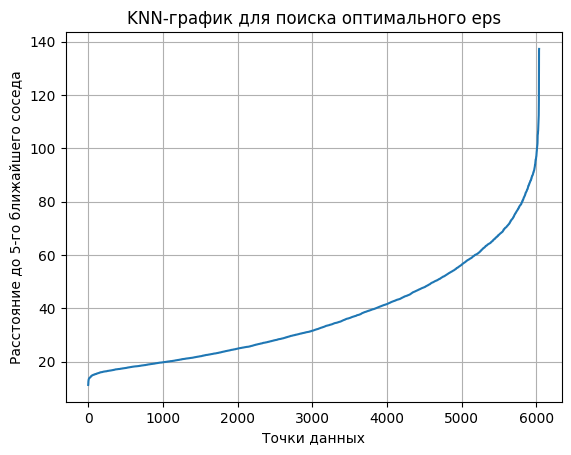

In [135]:
# Определяем количество ближайших соседей (например, 5)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(train_matrix_dense)

# Находим расстояния до ближайших соседей
distances, indices = neighbors_fit.kneighbors(train_matrix_dense)

# Сортируем расстояния для построения графика
distances = np.sort(distances[:, 4], axis=0)  # Берем расстояние до 5-го соседа (n_neighbors - 1)

# Построение графика
plt.plot(distances)
plt.title("KNN-график для поиска оптимального eps")
plt.xlabel("Точки данных")
plt.ylabel("Расстояние до 5-го ближайшего соседа")
plt.grid(True)
plt.show()

In [136]:
# DBSCAN отдельно, так как у него нет параметра количества кластеров
dbscan = DBSCAN(eps=50, min_samples=3)
labels_dbscan = dbscan.fit_predict(train_matrix_dense)
silhouette_avg_dbscan = silhouette_score(train_matrix_dense, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1
silhouette_dbscan.append(silhouette_avg_dbscan)

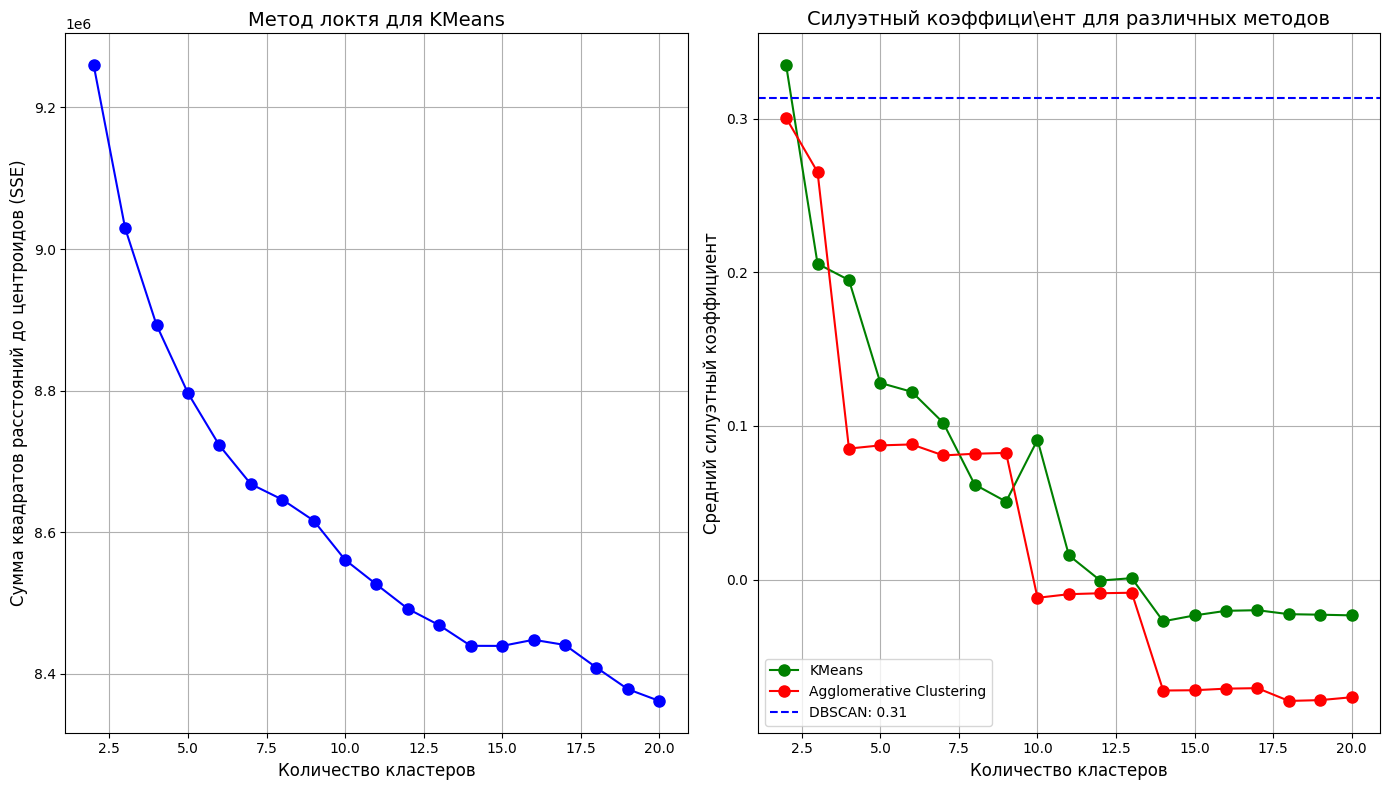

In [137]:
# Построение графиков для KMeans и иерархической кластеризации
plt.figure(figsize=(14, 8))

# График метода локтя для KMeans
plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_kmeans, 'bo-', markersize=8)
plt.title('Метод локтя для KMeans', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Сумма квадратов расстояний до центроидов (SSE)', fontsize=12)
plt.grid(True)

# График силуэтного коэффициента для KMeans и Agglomerative Clustering
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_kmeans, 'go-', markersize=8, label='KMeans')
plt.plot(cluster_range, silhouette_agg, 'ro-', markersize=8, label='Agglomerative Clustering')
plt.axhline(y=silhouette_avg_dbscan, color='b', linestyle='--', label=f'DBSCAN: {silhouette_avg_dbscan:.2f}')
plt.title('Силуэтный коэффици\ент для различных методов', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Средний силуэтный коэффициент', fontsize=12)
plt.legend()
plt.grid(True)

# Показать графики
plt.tight_layout()
plt.show()

In [138]:
best_n_clusters = 10

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
clusters_kmeans = kmeans.fit_predict(train_matrix_dense)

agg_clustering = AgglomerativeClustering(n_clusters=best_n_clusters)
clusters_agg = agg_clustering.fit_predict(train_matrix_dense)

dbscan = DBSCAN(eps=50, min_samples=5)
clusters_dbscan = dbscan.fit_predict(train_matrix_dense)

# Создаем DataFrame с user_id и результатами кластеризации
df_clusters = pd.DataFrame({
    'user_id': np.arange(train_matrix_dense.shape[0]),
    f'kmeans_{best_n_clusters}': clusters_kmeans,
    f'agg_{best_n_clusters}': clusters_agg,
    'dbscan': clusters_dbscan
})

print(df_clusters.shape)
df_clusters.head(2)

(6040, 4)


,user_id,kmeans_10,agg_10,dbscan
0,0,9,1,-1
1,1,9,1,-1


## Load Bert скоры

In [254]:
bert_df = pd.read_csv("bert_scores.csv")

In [255]:
bert_df

,score,user_id,item_id
0,3.555735,3,3365
1,3.100103,3,2169
2,2.744960,3,3390
3,2.702602,3,94
4,2.657003,3,1316
...,...,...,...
603995,5.867575,6027,2403
603996,5.855032,6027,1491
603997,5.851704,6027,3372
603998,5.719835,6027,748


## Сбор общего датафрейма для обучения бустинга

In [318]:
# Собранные результаты базовых моделей
## als_df, recomemendations_df_knn, df_scores_i2i, popular_df, df_clusters, df_faiss, 

all_models_df = als_df.merge(df_scores_i2i, on=['user_id', 'item_id'], how='outer')\
                        .merge(popular_df, on=['user_id', 'item_id'], how='outer')\
                        .merge(df_clusters, on=['user_id'], how='outer')\
                        .merge(recomemendations_df_knn, on=['user_id', 'item_id'], how='outer')\
                        .merge(bert_df.rename(columns={'score':'score_bert'}), on=['user_id', 'item_id'], how='outer')


                        # .merge(df_faiss, on=['user_id', 'item_id'], how='outer')\

In [319]:
df_scores_i2i['item_id'].max(), popular_df['item_id'].max(), \
df_clusters['user_id'].max(), df_faiss['item_id'].max(), \
recomemendations_df_knn['item_id'].max(), bert_df['item_id'].max()

(3705, 3705, 6039, 6039, 2957, 3705)

In [320]:
all_models_df = all_models_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')

In [321]:
all_models_df[['user_id', 'item_id']].duplicated().sum()

0

In [322]:
all_models_df = all_models_df.merge(item_features, on='item_id', how='left')

In [323]:
events['item_id'].max()

3705

In [324]:
all_models_df.shape

(5913612, 40)

In [325]:
# обработка и мержинг фичей
df_user = df[['user_id', 'user_avg_rating', 'user_min_rating', 'user_max_rating', 'user_rating_count', 
              'user_rating_std', 'user_unique_items', 'user_start_time', 'last_user_activity', 'user_activity_timedelta', 'user_positive_items', 
              'user_unwatched_ratio', 'user_positive_rating_count', 'user_positive_rating_ratio', 'user_bias', 'rating_user_cummean',
              'rating_user_normalized', 'rating_user_normalized_round', 'gender', 'age', 'gender_age_avg_rating',
              'top_2_avg_rating_user', 'top_4_avg_rating_user', 
              'top_6_avg_rating_user', 'top_8_avg_rating_user', 'top_10_avg_rating_user', 'top_12_avg_rating_user', 'top_14_avg_rating_user', 
              'top_16_avg_rating_user', 'top_18_avg_rating_user', 'top_20_avg_rating_user', 'top_22_avg_rating_user', 'top_24_avg_rating_user', 
              'top_26_avg_rating_user', 'top_28_avg_rating_user', 'top_30_avg_rating_user', 'top_32_avg_rating_user', 'top_34_avg_rating_user', 
              'top_36_avg_rating_user', 'top_38_avg_rating_user', 'top_40_avg_rating_user', 'top_42_avg_rating_user', 'top_44_avg_rating_user', 
              'top_46_avg_rating_user', 'top_48_avg_rating_user', 'top_50_avg_rating_user', 'rating_user_cumsum', 'rating_user_cumcount', 
              'gender_age_min_rating', 'gender_age_max_rating', 'gender_age_rating_count', 'gender_age_unique_users', 'gender_age_start_time', 
              'gender_age_last_activity', 'gender_age_positive_items', 'gender_age_positive_ratio', 'user_gender_age_avg_rating', 
              'user_gender_age_min_rating', 'user_gender_age_max_rating', 'user_gender_age_rating_count', 'user_gender_age_positive_items', 
              'gender_age_rating_variance', 'gender_age_rating_std', 'overall_gender_age_avg_rating', 'user_gender_age_bias']]

df_user = df_user.groupby(by='user_id').last().reset_index()

df_item = df[list(set(df.columns) - set(df_user.columns) - set(['rating', 'item_id_idx', 'timestamp','user_id_idx']))]
df_item = df_item.groupby(by='item_id').last().reset_index()

In [326]:
all_models_df = all_models_df.merge(df_user, how='left', on='user_id')\
                             .merge(df_item, how='left', on='item_id')

print(all_models_df.shape)


print(all_models_df.shape)

(5913612, 146)
(5913612, 146)


In [327]:
# Save
all_models_df.to_parquet('all_models_df_v2.parquet')

### Сбор таргета

In [328]:
not_train_data_glob['target'] = 1
all_models_df = all_models_df.merge(not_train_data_glob[['user_id', 'item_id', 'target']], on=['user_id', 'item_id'], how='left')
all_models_df['target'] = all_models_df['target'].fillna(0)
all_models_df['target'].value_counts(), not_train_data_glob.shape[0]

(target
 0.0    5841681
 1.0      71931
 Name: count, dtype: int64,
 71938)

In [317]:
bert_df

,score,user_id,item_id
0,3.555735,3,3365
1,3.100103,3,2169
2,2.744960,3,3390
3,2.702602,3,94
4,2.657003,3,1316
...,...,...,...
603995,5.867575,6027,2403
603996,5.855032,6027,1491
603997,5.851704,6027,3372
603998,5.719835,6027,748


In [316]:
all_models_df

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,score,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,item_avg_rating,top_34_avg_rating_item,top_32_avg_rating_item,item_positive_rating_ratio,top_40_avg_rating_item,top_16_avg_rating_item,top_12_avg_rating_item,item_max_rating,top_18_avg_rating_item,top_10_avg_rating_item,top_38_avg_rating_item,item_unique_users,rating_item_normalized,rating_item_cummean,item_min_rating,last_item_rating_time,top_20_avg_rating_item,top_44_avg_rating_item,item_olden,rating_item_normalized_round,item_recency,top_28_avg_rating_item,item_rating_diversity,top_22_avg_rating_item,rating_item_cumcount,item_rating_count,top_4_avg_rating_item,top_14_avg_rating_item,top_2_avg_rating_item,top_24_avg_rating_item,top_50_avg_rating_item,top_46_avg_rating_item,rating_item_cumsum,first_item_rating_time,top_8_avg_rating_item,top_42_avg_rating_item,top_6_avg_rating_item,top_26_avg_rating_item,top_48_avg_rating_item,top_36_avg_rating_item,item_positive_rating_count,top_30_avg_rating_item,target
0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,0.556113,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.979094,1,5,287,0.896525,287,0,326,1.139860,211,0.922222,211.0,0.735192,0.398147,3.993007,-1.979094,-2.0,1,35,3.604507,2.0,2.5,2.500000,2.50,2.2,2.333333,2.214286,2.0625,2.055556,2.05,2.090909,2.083333,2.192308,2.214286,2.166667,2.125,2.147059,2.250000,2.263158,2.225,2.238095,2.250000,2.282609,2.354167,2.38,1142,286,1,5,133694,855,0,1740,77769,0.581694,3.979094,1,5,287,211,1.163616,1.07871,3.604507,0.374587,3.655963,3.705882,3.68750,0.573394,3.625000,3.7500,3.750000,5.0,3.722222,3.9,3.631579,218.0,0.344037,3.672811,1.0,1413.0,3.80,3.636364,720.0,0.0,692.0,3.678571,5.0,3.772727,217.0,218.0,4.00,3.714286,4.5,3.666667,3.720000,3.695652,797.0,1.0,3.750,3.619048,4.000000,3.653846,3.729167,3.694444,125.0,3.666667,0.0
1,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,0.545099,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.979094,1,5,287,0.896525,287,0,326,1.139860,211,0.922222,211.0,0.735192,0.398147,3.993007,-1.979094,-2.0,1,35,3.604507,2.0,2.5,2.500000,2.50,2.2,2.333333,2.214286,2.0625,2.055556,2.05,2.090909,2.083333,2.192308,2.214286,2.166667,2.125,2.

In [329]:
f1 = (all_models_df['target'] != 1)
f2 = (all_models_df['score_bert'].isna())
f3 = (all_models_df['score_als'].isna())
f4 = (all_models_df['score_item2item_NL'].isna())
f_all = f1 & f2 & f3 & f4

In [332]:
all_models_df

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,score_bert,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,item_avg_rating,top_34_avg_rating_item,top_32_avg_rating_item,item_positive_rating_ratio,top_40_avg_rating_item,top_16_avg_rating_item,top_12_avg_rating_item,item_max_rating,top_18_avg_rating_item,top_10_avg_rating_item,top_38_avg_rating_item,item_unique_users,rating_item_normalized,rating_item_cummean,item_min_rating,last_item_rating_time,top_20_avg_rating_item,top_44_avg_rating_item,item_olden,rating_item_normalized_round,item_recency,top_28_avg_rating_item,item_rating_diversity,top_22_avg_rating_item,rating_item_cumcount,item_rating_count,top_4_avg_rating_item,top_14_avg_rating_item,top_2_avg_rating_item,top_24_avg_rating_item,top_50_avg_rating_item,top_46_avg_rating_item,rating_item_cumsum,first_item_rating_time,top_8_avg_rating_item,top_42_avg_rating_item,top_6_avg_rating_item,top_26_avg_rating_item,top_48_avg_rating_item,top_36_avg_rating_item,item_positive_rating_count,top_30_avg_rating_item,target
0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,0.556113,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.979094,1,5,287,0.896525,287,0,326,1.139860,211,0.922222,211.0,0.735192,0.398147,3.993007,-1.979094,-2.0,1,35,3.604507,2.0,2.5,2.500000,2.50,2.2,2.333333,2.214286,2.0625,2.055556,2.05,2.090909,2.083333,2.192308,2.214286,2.166667,2.125,2.147059,2.250000,2.263158,2.225,2.238095,2.250000,2.282609,2.354167,2.38,1142,286,1,5,133694,855,0,1740,77769,0.581694,3.979094,1,5,287,211,1.163616,1.07871,3.604507,0.374587,3.655963,3.705882,3.68750,0.573394,3.625000,3.7500,3.750000,5.0,3.722222,3.9,3.631579,218.0,0.344037,3.672811,1.0,1413.0,3.80,3.636364,720.0,0.0,692.0,3.678571,5.0,3.772727,217.0,218.0,4.00,3.714286,4.5,3.666667,3.720000,3.695652,797.0,1.0,3.750,3.619048,4.000000,3.653846,3.729167,3.694444,125.0,3.666667,0.0
1,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,0.545099,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.979094,1,5,287,0.896525,287,0,326,1.139860,211,0.922222,211.0,0.735192,0.398147,3.993007,-1.979094,-2.0,1,35,3.604507,2.0,2.5,2.500000,2.50,2.2,2.333333,2.214286,2.0625,2.055556,2.05,2.090909,2.083333,2.192308,2.214286,2.166667,2.1

In [334]:
all_models_df = all_models_df[~f_all]

In [335]:
all_models_df['target'].mean()

0.027023635678517503

In [336]:
all_models_df = all_models_df.fillna(-999)

# all_models_df[['score_l2', 'score_ip', 'score_total']] = all_models_df[['score_l2', 'score_ip', 'score_total']].replace(-1, -999)

print(all_models_df.shape)

(2661781, 147)


In [337]:
def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    # Проверяем, что размеры разделения корректны
    assert train_size + val_size + test_size == 1, "Сумма размеров должна быть равна 1"
    
    # Первое разделение: train и временный (вал+тест)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    
    # Второе разделение: вал+тест разбивается на вал и тест
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(all_models_df.drop(['user_id', 'item_id','target'], axis=1), all_models_df['target'])

## Обучение реранжирующего бустинга

In [339]:
from sklearn.metrics import log_loss

In [340]:
# Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 2, 7),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5.5),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli" ]), # "MVS"
        "random_seed": 42,
        "verbose": 0,
    }
    
    # Установка параметра bootstrap
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1.0)

    # Инициализация
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
        verbose=0,
        callbacks=[optuna.integration.CatBoostPruningCallback(trial, "Logloss")]
    )

    # Предикт AUC
    y_pred = model.predict_proba(X_val)[:, 1]
    logloss = log_loss(y_val, y_pred)
    return logloss

# Define a study with a pruner
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)  # Change n_warmup_steps as needed
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=10, timeout=3600)

# Output best trial results
print("Best Logloss:", study.best_value)
print("Best parameters:", study.best_trial.params)

# Optionally save study results
optuna_results = pd.DataFrame([trial.params for trial in study.trials])
optuna_results.to_csv("optuna_catboost_results.csv", index=False)

[I 2024-10-25 23:01:30,154] A new study created in memory with name: no-name-6e6eff72-6cac-4c0d-94e7-577686d9dea7
[I 2024-10-25 23:01:45,354] Trial 0 finished with value: 0.01207501542925989 and parameters: {'iterations': 127, 'depth': 6, 'learning_rate': 0.011354263609314977, 'l2_leaf_reg': 2.049984015944943, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9097803588153226}. Best is trial 0 with value: 0.01207501542925989.
[I 2024-10-25 23:02:29,846] Trial 1 finished with value: 0.008626884848924926 and parameters: {'iterations': 681, 'depth': 4, 'learning_rate': 0.1747981553856093, 'l2_leaf_reg': 3.7671466723393108, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6745926240241975}. Best is trial 1 with value: 0.008626884848924926.
[I 2024-10-25 23:03:55,574] Trial 2 finished with value: 0.00801910341316202 and parameters: {'iterations': 912, 'depth': 6, 'learning_rate': 0.15417884944380916, 'l2_leaf_reg': 0.6209221115826713, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12651597

Best Logloss: 0.00801910341316202
Best parameters: {'iterations': 912, 'depth': 6, 'learning_rate': 0.15417884944380916, 'l2_leaf_reg': 0.6209221115826713, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12651597619263266}


In [341]:
study.best_trial.params

{'iterations': 912,
 'depth': 6,
 'learning_rate': 0.15417884944380916,
 'l2_leaf_reg': 0.6209221115826713,
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 0.12651597619263266}

In [342]:
final_catboost = CatBoostClassifier(**study.best_trial.params, random_seed=42)
final_catboost.fit(all_models_df.drop(['user_id', 'item_id','target'], axis=1), all_models_df['target'], verbose=0)

In [343]:
all_models_df['target'].sum()

71931.0

In [344]:
result_pred = final_catboost.predict_proba(all_models_df.drop(['user_id', 'item_id','target'], axis=1))[:, 1]
result_pred_tresh = np.where(result_pred > 0.1, 1, 0)

print(classification_report(all_models_df['target'], result_pred_tresh))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00   2589850
         1.0       0.82      0.99      0.90     71931

    accuracy                           0.99   2661781
   macro avg       0.91      0.99      0.95   2661781
weighted avg       0.99      0.99      0.99   2661781



In [212]:
# result_pred = final_catboost.predict_proba(X_test)[:, 1]
# result_pred_tresh = np.where(result_pred > 0.1, 1, 0)

# print(classification_report(y_test, result_pred_tresh))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    856608
         1.0       0.31      0.84      0.45     10700

    accuracy                           0.97    867308
   macro avg       0.65      0.91      0.72    867308
weighted avg       0.99      0.97      0.98    867308



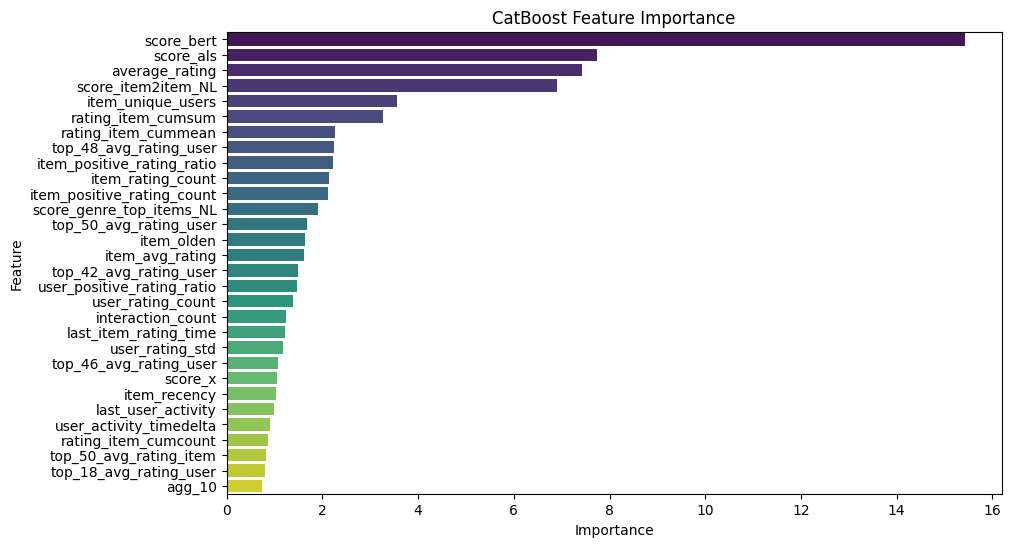

In [345]:
# Получаем важность признаков
feature_importances = final_catboost.feature_importances_
features = X_test.columns

# Создаем DataFrame для удобства
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Сортируем по убыванию важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(30)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('CatBoost Feature Importance')
plt.show()

In [215]:
final_catboost.feature_names_

['score_als',
 'score_item2item_NL',
 'score_last_1_NL',
 'score_last_2_NL',
 'score_last_3_NL',
 'score_last_4_NL',
 'score_last_5_NL',
 'score_top_pop_NL',
 'score_genre_top_items_NL',
 'interaction_count',
 'average_rating',
 'score_x',
 'popularity_score_dumb',
 'average_rating_dumb',
 'kmeans_10',
 'agg_10',
 'dbscan',
 'score_l2',
 'score_ip',
 'score_total',
 'score_y',
 'distance',
 'user_avg_rating',
 'user_min_rating',
 'user_max_rating',
 'user_rating_count',
 'user_rating_std',
 'user_unique_items',
 'user_start_time',
 'last_user_activity',
 'user_activity_timedelta',
 'user_positive_items',
 'user_unwatched_ratio',
 'user_positive_rating_count',
 'user_positive_rating_ratio',
 'user_bias',
 'rating_user_cummean',
 'rating_user_normalized',
 'rating_user_normalized_round',
 'gender',
 'age',
 'gender_age_avg_rating',
 'top_2_avg_rating_user',
 'top_4_avg_rating_user',
 'top_6_avg_rating_user',
 'top_8_avg_rating_user',
 'top_10_avg_rating_user',
 'top_12_avg_rating_user',


In [346]:
all_models_df['result_pred'] = result_pred

In [347]:
events_merge = events.copy()
events_merge['flag'] = 1

In [348]:
all_models_df = all_models_df.merge(events_merge[['user_id', 'item_id', 'flag']], how='left')
print(all_models_df.shape)
all_models_df = all_models_df[all_models_df['flag'] != 1]
print(all_models_df.shape)

(2661781, 149)
(2484354, 149)


In [349]:
submit_res = all_models_df[['user_id', 'item_id', 'result_pred']].sort_values(['user_id', 'result_pred'], ascending=[True, False]).groupby('user_id')[['user_id','item_id']].head(10).reset_index(drop=True)

In [350]:
all_models_df[['user_id', 'item_id', 'result_pred']][all_models_df['user_id'] == 0].sort_values('result_pred')

,user_id,item_id,result_pred
274,0,2165,6.822181e-12
203,0,1614,1.633490e-11
60,0,487,2.632534e-11
419,0,3298,2.823910e-11
292,0,2336,2.901016e-11
...,...,...,...
111,0,880,3.258069e-02
37,0,339,5.523682e-02
390,0,3027,6.766921e-02
209,0,1675,7.439781e-02


In [351]:
# Объединяем данные по user_id
merged_df = events[['user_id', 'item_id']].merge(submit_res[['user_id', 'item_id']], on='user_id')

# Проверка на пересечение item_id
mask = merged_df['item_id_x'] == merged_df['item_id_y']
intersections = merged_df[mask]

# Статистика о пересечении
print(f"Количество пересечений: {len(intersections)}")
print("Пересечения:")
print(intersections)

Количество пересечений: 0
Пересечения:
Empty DataFrame
Columns: [user_id, item_id_x, item_id_y]
Index: []


In [352]:
submit_res = submit_res.groupby('user_id')['item_id'].apply(lambda x: ' '.join(map(str, x))).reset_index()

In [353]:
submit_res['user_id'] = submit_res['user_id'].astype(str)
submit_res

,user_id,item_id
0,0,801 1675 3027 339 880 1729 1137 423 1307 2396
1,1,1868 1671 2484 2860 1822 3071 1603 2612 3412 2322
2,2,2587 2125 561 829 353 2862 456 3182 2442 2347
3,3,1053 3309 3501 827 3023 1015 3417 1324 1140 2467
4,4,1583 2437 304 3332 1279 901 2409 2877 734 473
...,...,...
6035,6035,3187 1012 2885 2564 2469 1590 3652 2483 2802 289
6036,6036,2023 1657 36 3069 1631 2360 338 1189 2243 2649
6037,6037,3474 2335 560 1605 2618 3653 513 2430 1703 3668
6038,6038,3187 2950 2799 570 299 1355 1706 2923 3309 136


In [354]:
submit_res.to_csv('submit_The_boys_bert_boost.csv', index=False)